## Solving the multi-arm bandit

Let’s say you’re at a casino, and in front of you are 10 slot machines with a flashy
sign that says “Play for free! Max payout is $10!” Wow, not bad! Intrigued, you ask one
of the employees what’s going on, because it seems too good to be true, and she says,
“It’s really true, play as much as you want, it’s free. Each slot machine is guaranteed to
give you a reward between $0 and $10. Oh, by the way, keep this to yourself, but those
10 slot machines each have a different average payout, so try to figure out which one
gives the most rewards on average, and you’ll be making tons of cash!”

**Strategy**

- We do a exploitation (choose best machine) and exploration (choose random machine) of slot machines
- choose a parameter (epsilon) that can control between the two approaches.
- Get average of each slot machine output. We take a fixed random number (probability) for each machine and add one dollar each time a random number comes greater than the probability. 
- For each arm (action): set up a for loop going to 10 (max reward), and at each step it will add 1 to the reward if a
random float is less than the arm’s probability. RUnning this for many iterations will give the value (prob*max_reward).

In [ ]:
import numpy as np

# Number of slot machines/arms
N = 10

# probability for each arm 
prob_a = np.random.rand(N)


# get reward for an arm with given probability
def get_reward(prob, max_reward=10):
    reward = 0
    for i in range(max_reward):
        if np.random.random() < prob:
            reward += 1
    return reward



# function to update the reward for an action (a) of chosing an arm at each iteration
def update_reward(record,a,reward):
    
    # update the mean and count of the arm a
    new_mean = (record[a][1]*record[a][0]+reward)/(record[a][0]+1)
    record[a][0] += 1
    record[a][1] = new_mean
    
    return record


# function to choose an arm to pull at each iteration
def choose_arm(record,epsilon):
    # choose a random number between 0 and 1
    rand = np.random.rand()
    
    # if the random number is less than epsilon, choose a random arm
    if rand < epsilon:
        return np.random.randint(N)
    
    # else, choose the arm with the highest mean reward
    else:
        return np.argmax(record[:,1],axis=0)
    

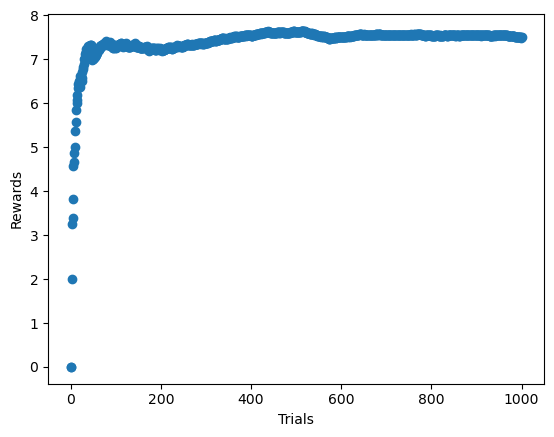

In [30]:
import matplotlib.pyplot as plt

# number of iterations
iterations = 1000

# epsilon for exploration
epsilon = 0.2

# record array with shape (N,2) 
# col1: the number of times each arm has been pulled 
# col2: the total reward for each arm
record = np.zeros((N,2))


fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Trials')
ax.set_ylabel(r'Rewards')

rewards=[0]
# loop over iterations
for i in range(iterations):
    # choose an arm to pull
    a = choose_arm(record,epsilon)
    
    # get the reward for the chosen arm
    reward_i = get_reward(prob_a[a])
    
    # update the reward for the chosen arm
    record = update_reward(record,a,reward_i)
    mean_reward = ((i+1) * rewards[-1] + reward_i)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)